# Using the `autocuts` and `IterCut` Algorithms
_____
This is a quick look at how to use the `autocuts` and the `IterCut` algorithms. The `autocuts` function acts as a black box (the user cannot see what is going on under the hood), while `IterCut` allows the user to understand each cut being applied to data. For quick results, `autocuts` is usually sufficient, but `IterCut` is very useful to actually understand what is happening.

Note that there are many more optional arguments than what are shown here in the notebook. As always, we recommend reading the docstrings!

First, let's import our functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qetpy import autocuts, calc_psd, IterCut

Now, let's load the data.

In [2]:
pathtodata = "test_autocuts_data.npy"
traces = np.load(pathtodata)
fs = 625e3

Let's look at the PSD before the cuts, to get a sense of the change.

In [3]:
f, psd = calc_psd(traces, fs=fs, folded_over=True)

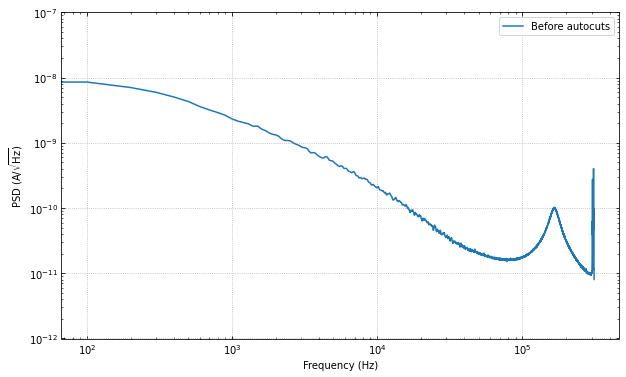

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(f, np.sqrt(psd), label="Before autocuts")
ax.set_ylim([1e-12,1e-7])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (A/$\sqrt{\mathrm{Hz}}$)')
ax.legend(loc="upper right")
ax.grid(linestyle='dotted')
ax.tick_params(which='both',direction='in',right=True,top=True)

## Using `autocuts`

Apply the autocuts function.

In [5]:
?autocuts

Signature:
autocuts(
    traces,
    fs=625000.0,
    template=None,
    psd=None,
    is_didv=False,
    outlieralgo='iterstat',
    lgcpileup1=True,
    lgcslope=True,
    lgcbaseline=True,
    lgcpileup2=True,
    lgcchi2=True,
    nsigpileup1=2,
    nsigslope=2,
    nsigbaseline=2,
    nsigpileup2=2,
    nsigchi2=3,
    **kwargs,
)
Docstring:
Function to automatically cut out bad traces based on the optimum
filter amplitude, slope, baseline, and chi^2 of the traces.

Parameters
----------
traces : ndarray
    2-dimensional array of traces to do cuts on
fs : float, optional
    Sample rate that the data was taken at
is_didv : bool, optional
    Boolean flag on whether or not the trace is a dIdV curve
outlieralgo : string, optional
    Which outlier algorithm to use. If set to "removeoutliers",
    uses the removeoutliers algorithm that removes data based on
    the skewness of the dataset. If set to "iterstat", uses the
    iterstat algorithm to remove data based on being outside a


In [6]:
cut = autocuts(
    traces,
    fs=fs,
)
print(f"The cut efficiency is {np.sum(cut)/len(traces):.3f}.")

The cut efficiency is 0.428.


Let's compare the PSD after the cuts, we should see the noise go down by a fair amount.

In [7]:
psd_cut = calc_psd(traces[cut], fs=fs, folded_over=True)[1]

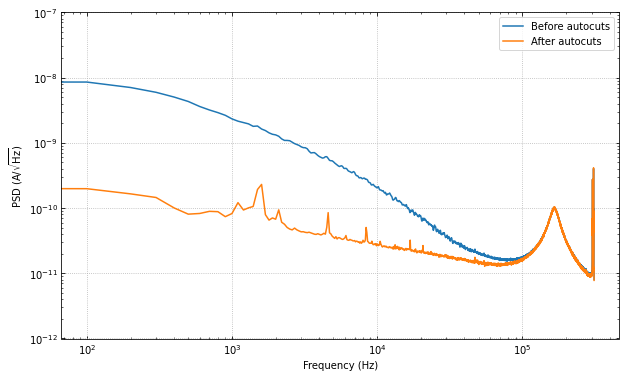

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(f, np.sqrt(psd), label="Before autocuts")
ax.loglog(f, np.sqrt(psd_cut), label="After autocuts")
ax.set_ylim([1e-12,1e-7])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (A/$\sqrt{\mathrm{Hz}}$)')
ax.legend(loc="upper right")
ax.grid(linestyle='dotted')
ax.tick_params(which='both',direction='in',right=True,top=True)

The change is huge! Which makes sense, as we have removed many of the pulses, muon tails, etc. Please note that there may still be "bad" traces in the data, as the autocuts function is not perfect. There may be more cuts that one would like to do that are more specific to the dataset.

## Using IterCut for better cut control

A good way of understanding the cuts further than using the black box that is `autocuts` is to use the object-oriented version `IterCut`. This class allows the user freedom in cut order, which cuts are used, which algorithms are used for outlier removal, and more.

Below, we match the default parameters and outlier algorithm (`iterstat`) to show that the cut efficiency is the same.

In [9]:
IC = IterCut(traces, fs)
IC.pileupcut(cut=2)
IC.slopecut(cut=2)
IC.baselinecut(cut=2)
IC.chi2cut(cut=3)
cut_ic = IC.cmask

In [10]:
print(f"The cut efficiency is {np.sum(cut_ic)/len(traces):.3f}.")

The cut efficiency is 0.428.


In [11]:
psd_cut = calc_psd(traces[cut_ic], fs=fs, folded_over=True)[1]

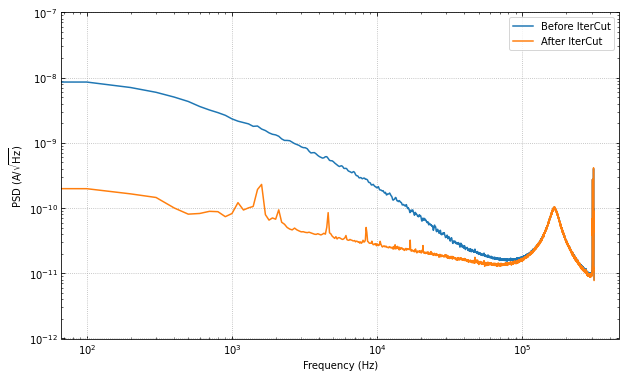

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(f, np.sqrt(psd), label="Before IterCut")
ax.loglog(f, np.sqrt(psd_cut), label="After IterCut")
ax.set_ylim([1e-12,1e-7])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (A/$\sqrt{\mathrm{Hz}}$)')
ax.legend(loc="upper right")
ax.grid(linestyle='dotted')
ax.tick_params(which='both',direction='in',right=True,top=True)

With `IterCut` we can also access the cuts at each step as they have been iteratively applied, and there is a verbose option for plotting the passing event and failing events for each cut.

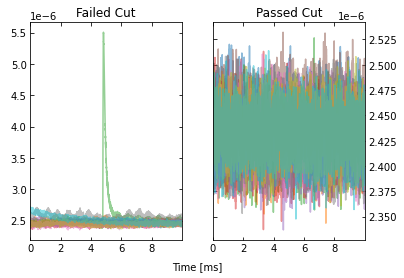

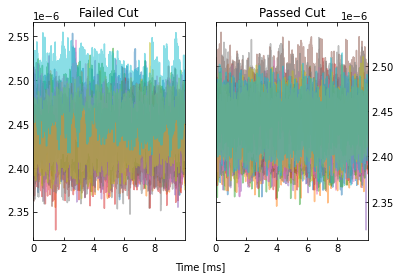

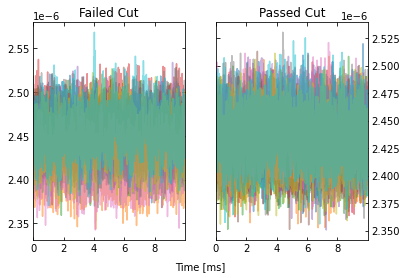

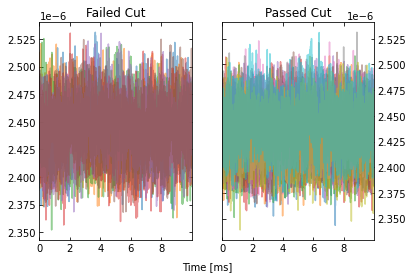

In [13]:
IC = IterCut(traces, fs, verbose=True)
cpileup = IC.pileupcut(cut=2)
cslope = IC.slopecut(cut=2)
cbaseline = IC.baselinecut(cut=2)
cchi2 = IC.chi2cut(cut=3)
cut_ic = IC.cmask

This allows to calculate the efficiency of each cut, and we can see what cuts are going the heavy lifting. Note the importance of the denominator being the number of events that passed the previous cuts when calculating these efficiencies. If we were to divide by the number of traces each time, then this would be the total cut efficiency up to that cut. Below, we show the individual performance of each cut.

In [14]:
print(f"The pileup cut efficiency is {np.sum(cpileup)/len(traces):.3f}.")
print(f"The slope cut efficiency is {np.sum(cslope)/np.sum(cpileup):.3f}.")
print(f"The baseline cut efficiency is {np.sum(cbaseline)/np.sum(cslope):.3f}.")
print(f"The chi2 cut efficiency is {np.sum(cchi2)/np.sum(cbaseline):.3f}.")
print("-------------")
print(f"The total cut efficiency is {np.sum(cut_ic)/len(traces):.3f}.")

The pileup cut efficiency is 0.679.
The slope cut efficiency is 0.719.
The baseline cut efficiency is 0.889.
The chi2 cut efficiency is 0.986.
-------------
The total cut efficiency is 0.428.


Thus, we see that the pileup cut is has the lowest efficiency, with the slope cut as a close second. If we were to remove the baseline and chi-squared cuts, then we would expect the PSD to not change noticeably. Let's test this expectation.

In [15]:
IC = IterCut(traces, fs)
cpileup = IC.pileupcut(cut=2)
cslope = IC.slopecut(cut=2)
cut_ic = IC.cmask

In [16]:
print(f"The pileup cut efficiency is {np.sum(cpileup)/len(traces):.3f}.")
print(f"The slope cut efficiency is {np.sum(cslope)/np.sum(cpileup):.3f}.")
print("-------------")
print(f"The total cut efficiency is {np.sum(cut_ic)/len(traces):.3f}.")

The pileup cut efficiency is 0.679.
The slope cut efficiency is 0.719.
-------------
The total cut efficiency is 0.488.


In [17]:
psd_cut = calc_psd(traces[cut_ic], fs=fs, folded_over=True)[1]

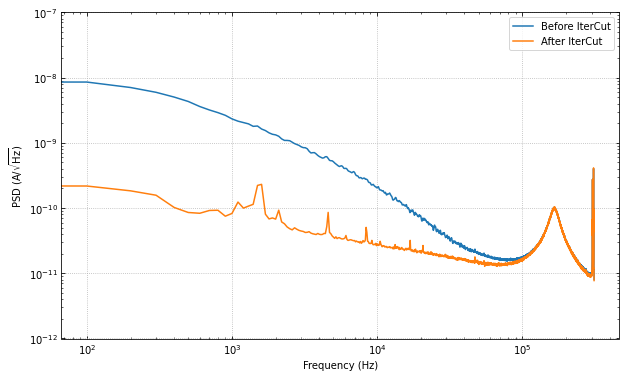

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(f, np.sqrt(psd), label="Before IterCut")
ax.loglog(f, np.sqrt(psd_cut), label="After IterCut")
ax.set_ylim([1e-12,1e-7])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (A/$\sqrt{\mathrm{Hz}}$)')
ax.legend(loc="upper right")
ax.grid(linestyle='dotted')
ax.tick_params(which='both',direction='in',right=True,top=True)

What if we reversed the cut order? How does this affect the cut efficiencies?

In [19]:
IC = IterCut(traces, fs, verbose=False)
cchi2 = IC.chi2cut(cut=3)
cbaseline = IC.baselinecut(cut=2)
cslope = IC.slopecut(cut=2)
cpileup = IC.pileupcut(cut=2)
cut_ic = IC.cmask

In [20]:
print(f"The chi2 cut efficiency is {np.sum(cchi2)/len(traces):.3f}.")
print(f"The baseline cut efficiency is {np.sum(cbaseline)/np.sum(cchi2):.3f}.")
print(f"The slope cut efficiency is {np.sum(cslope)/np.sum(cbaseline):.3f}.")
print(f"The pileup cut efficiency is {np.sum(cpileup)/np.sum(cslope):.3f}.")
print("-------------")
print(f"The total cut efficiency is {np.sum(cut_ic)/len(traces):.3f}.")

The chi2 cut efficiency is 0.840.
The baseline cut efficiency is 0.739.
The slope cut efficiency is 0.718.
The pileup cut efficiency is 0.706.
-------------
The total cut efficiency is 0.315.


In [21]:
psd_cut = calc_psd(traces[cut_ic], fs=fs, folded_over=True)[1]

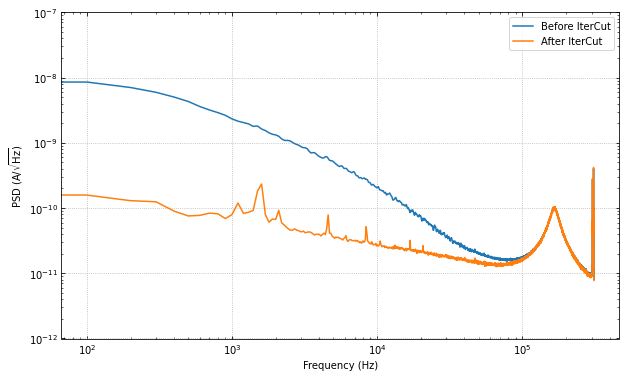

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(f, np.sqrt(psd), label="Before IterCut")
ax.loglog(f, np.sqrt(psd_cut), label="After IterCut")
ax.set_ylim([1e-12,1e-7])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (A/$\sqrt{\mathrm{Hz}}$)')
ax.legend(loc="upper right")
ax.grid(linestyle='dotted')
ax.tick_params(which='both',direction='in',right=True,top=True)

The PSD is essentially the same, but the pileup cut is no longer doing much, as we did it last (the previous three cuts ended cutting out a lot of pileup!). Thus, this shows that order does matter, and its worth thinking about what order makes the most sense in one's application.

## Advanced Usage: Arbitrary Cuts

For advanced users, `IterCut` includes an option to apply some arbitrary cut based on some function that isn't included by default (or some one-off user-defined function). As an example, let's add a maximum cut via `numpy.max`, but only finding the maximum up to some specified bin number in the trace.

In [23]:
maximum = lambda traces, end_index: np.max(traces[..., :end_index], axis=-1)

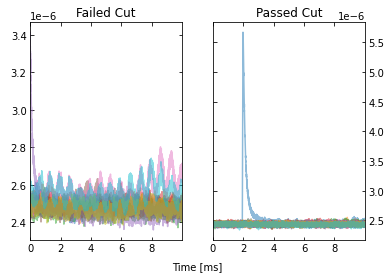

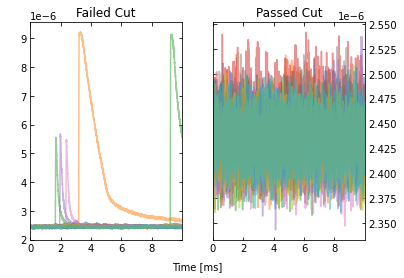

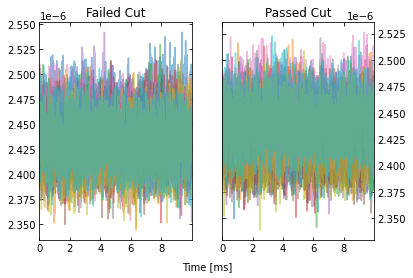

In [24]:
IC = IterCut(traces, fs, verbose=True)
cmaximum = IC.arbitrarycut(maximum, 200, cut=2)
cpileup = IC.pileupcut(cut=2)
cslope = IC.slopecut(cut=2)
cut_ic = IC.cmask

In [25]:
print(f"The maximum cut efficiency is {np.sum(cmaximum)/len(traces):.3f}.")
print(f"The pileup cut efficiency is {np.sum(cpileup)/np.sum(cmaximum):.3f}.")
print(f"The slope cut efficiency is {np.sum(cslope)/np.sum(cpileup):.3f}.")
print("-------------")
print(f"The total cut efficiency is {np.sum(cut_ic)/len(traces):.3f}.")

The maximum cut efficiency is 0.721.
The pileup cut efficiency is 0.742.
The slope cut efficiency is 0.763.
-------------
The total cut efficiency is 0.408.


Looking at the events that passed, we see that the maximum cut we applied allowed a "bad" trace (a trace with a pulse). This makes sense since we only looked at a portion of the trace for that cut, so it was not a very good cut. Fortunately, our pileup and slope cuts did a good job of removing the bad traces that passed the maximum cut.

Lastly, it's worth simply printing out the docstrings of the three different supported outlier algorithms. The `kwargs` vary considerably between each of them, so to specify them in `IterCut`, one must know which ones to use! For example, `iterstat` has the `cut` `kwarg`, which we were using in the above examples (because `iterstat` is the default outlier algorithm for these automated cut routines).

In [26]:
from qetpy.cut import iterstat, removeoutliers
from astropy.stats import sigma_clip

In [27]:
?iterstat

Signature: iterstat(data, cut=3, precision=1000.0, return_unbiased_estimates=False)
Docstring:
Function to iteratively remove outliers based on how many standard
deviations they are from the mean, where the mean and standard
deviation are recalculated after each cut.

Parameters
----------
data : ndarray
    Array of data that we want to remove outliers from.
cut : float, optional
    Number of standard deviations from the mean to be used for
    outlier rejection
precision : float, optional
    Threshold for change in mean or standard deviation such that we
    stop iterating. The threshold is determined by
    np.std(data)/precision. This means that a higher number for
    precision means a lower threshold (i.e. more iterations).
return_unbiased_estimates : bool, optional
    Boolean flag for whether or not to return the biased or
    unbiased estimates of the mean and standard deviation of the
    data. Default is False.

Returns
-------
datamean : float
    Mean of the data after o

In [28]:
?removeoutliers

Signature: removeoutliers(x, maxiter=20, skewtarget=0.05)
Docstring:
Function to return indices of inlying points, removing points
by minimizing the skewness.

Parameters
----------
x : ndarray
    Array of real-valued variables from which to remove outliers.
maxiter : float, optional
    Maximum number of iterations to continue to minimize skewness.
    Default is 20.
skewtarget : float, optional
    Desired residual skewness of distribution. Default is 0.05.

Returns
-------
inds : ndarray
    Boolean indices indicating which values to select/reject, same
    length as `x`.
File:      ~/.local/lib/python3.6/site-packages/qetpy/cut/_cut.py
Type:      function


In [29]:
?sigma_clip

Signature:
sigma_clip(
    data,
    sigma=3,
    sigma_lower=None,
    sigma_upper=None,
    maxiters=5,
    cenfunc='median',
    stdfunc='std',
    axis=None,
    masked=True,
    return_bounds=False,
    copy=True,
)
Docstring:
Perform sigma-clipping on the provided data.

The data will be iterated over, each time rejecting values that are
less or more than a specified number of standard deviations from a
center value.

Clipped (rejected) pixels are those where::

    data < cenfunc(data [,axis=int]) - (sigma_lower * stdfunc(data [,axis=int]))
    data > cenfunc(data [,axis=int]) + (sigma_upper * stdfunc(data [,axis=int]))

Invalid data values (i.e., NaN or inf) are automatically clipped.

For an object-oriented interface to sigma clipping, see
:class:`SigmaClip`.

.. note::
    `scipy.stats.sigmaclip
    <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sigmaclip.html>`_
    provides a subset of the functionality in this class.  Also, its
    input data cannot be a